In [1]:

from datetime import date, timedelta, datetime
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from datetime import timedelta
from pandas_datareader.data import DataReader


# Import packages
import seaborn as sns
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import fbprophet as prophet
import os
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go

In [2]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# Set up End and Start times for data grab
end = datetime.datetime.now().date()
start = datetime.datetime(end.year - 2, end.month, end.day)

#For loop for grabing yahoo finance data and setting as a dataframe
for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    globals()[stock] = DataReader(stock, 'yahoo', start, end)

In [3]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

High          Low         Open        Close     Volume  \
Date                                                                        
2022-01-18  3194.689941  3153.290039  3182.100098  3178.350098  3364600.0   
2022-01-19  3185.000000  3125.000000  3175.239990  3125.979980  2662100.0   
2022-01-20  3160.000000  3027.020020  3135.320068  3033.350098  3598700.0   
2022-01-21  3018.000000  2841.409912  2999.000000  2852.860107  8164200.0   
2022-01-24  2898.899902  2707.040039  2780.000000  2890.879883  7802200.0   
2022-01-25  2872.000000  2762.899902  2844.850098  2799.719971  4541200.0   
2022-01-26  2903.699951  2746.370117  2895.000000  2777.449951  4780100.0   
2022-01-27  2884.870117  2787.000000  2816.000000  2792.750000  3860100.0   
2022-01-28  2879.959961  2758.590088  2817.209961  2879.560059  3705700.0   
2022-01-31  3007.209961  2886.010010  2895.000000  2991.469971  3908900.0   

              Adj Close company_name  
Date                                  
2022-01-18  3178.350098       AMAZON  
2022-01-19  3125.979980       AMAZON  
2022-01-20  3033.350098       AMAZON  
2022-01-21  2852.860107       AMAZON  
2022-01-24  2890.879883       AMAZON  
2022-01-25  2799.719971       AMAZON  
2022-01-26  2777.449951       AMAZON  
2022-01-27  2792.750000       AMAZON  
2022-01-28  2879.560059       AMAZON  
2022-01-31  2991.469971       AMAZON

In [4]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols          AAPL         GOOG        MSFT         AMZN
Date                                                       
2020-02-03  76.035561  1485.939941  171.117691  2004.199951
2020-02-04  78.545776  1447.069946  176.750290  2049.669922
2020-02-05  79.186264  1448.229980  176.534424  2039.869995
2020-02-06  80.112503  1476.229980  180.194626  2050.229980
2020-02-07  79.023567  1479.229980  180.449783  2079.280029

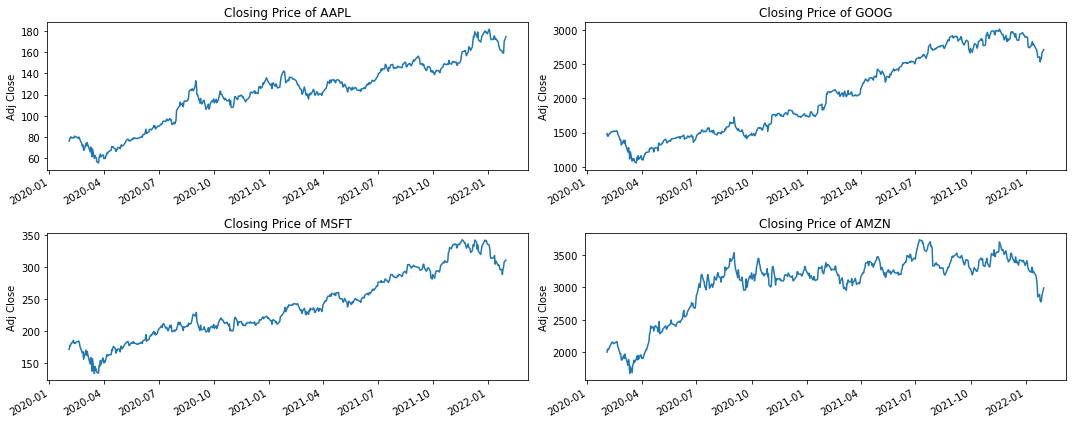

In [5]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

In [6]:
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols         AAPL      GOOG      MSFT      AMZN
Date                                              
2020-02-03       NaN       NaN       NaN       NaN
2020-02-04  0.033014 -0.026159  0.032917  0.022687
2020-02-05  0.008154  0.000802 -0.001221 -0.004781
2020-02-06  0.011697  0.019334  0.020734  0.005079
2020-02-07 -0.013593  0.002032  0.001416  0.014169

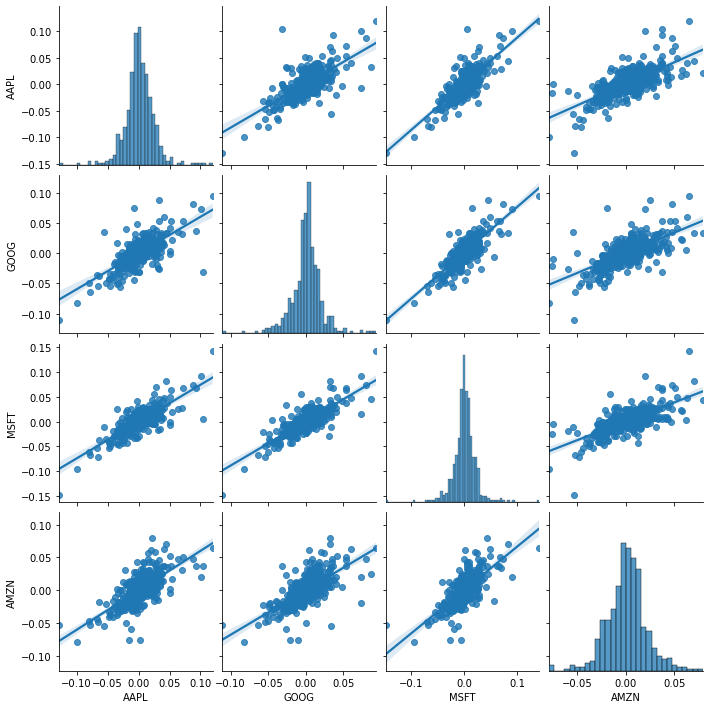

In [7]:
sns.pairplot(tech_rets, kind='reg')

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

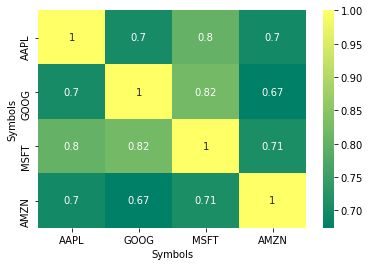

In [8]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

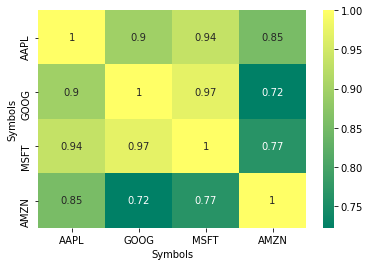

In [9]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

## ANALYSIS AND FORECAST OF THE  STOCK PRICE OF "MSFT"

#### Set date timestamps for historical data download

In [10]:

start_date = datetime.datetime(2015, 1, 1).date()
end_date = datetime.datetime.now().date()
start_date, end_date

(datetime.date(2015, 1, 1), datetime.date(2022, 2, 1))

In [11]:
ticker = "MSFT"
msft = yf.Ticker(ticker)

msft

yfinance.Ticker object <MSFT>

In [12]:
msft.info

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 181000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. Its Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions; and training and certifica

In [13]:
#take the data between the two given dates
historical_data = msft.history(start=start_date, end=end_date, interval="1d").reset_index()

historical_data.shape

(1784, 8)

In [14]:
historical_data.head()

Date       Open       High        Low      Close    Volume  Dividends  \
0 2014-12-31  41.167414  41.792898  40.920746  40.920746  21552500        0.0   
1 2015-01-02  41.105749  41.775280  41.000034  41.193844  27913900        0.0   
2 2015-01-05  40.850265  41.167412  40.744550  40.815029  39673900        0.0   
3 2015-01-06  40.859080  41.185035  40.119070  40.215977  36447900        0.0   
4 2015-01-07  40.506680  40.929542  40.075010  40.726921  29114100        0.0   

   Stock Splits  
0             0  
1             0  
2             0  
3             0  
4             0

In [15]:
historical_data.describe()

Open         High          Low        Close        Volume  \
count  1784.000000  1784.000000  1784.000000  1784.000000  1.784000e+03   
mean    123.482742   124.642974   122.267244   123.522578  3.009275e+07   
std      82.604816    83.393917    81.754641    82.618914  1.431110e+07   
min      35.758302    36.145860    35.441154    35.590923  7.425600e+06   
25%      53.440587    53.680923    53.203013    53.452023  2.140872e+07   
50%      97.928087    98.451267    96.815928    97.894085  2.648910e+07   
75%     178.544271   180.718357   175.477075   179.031620  3.419928e+07   
max     344.619995   349.670013   342.200012   343.109985  1.691640e+08   

         Dividends  Stock Splits  
count  1784.000000        1784.0  
mean      0.006923           0.0  
std       0.055846           0.0  
min       0.000000           0.0  
25%       0.000000           0.0  
50%       0.000000           0.0  
75%       0.000000           0.0  
max       0.620000           0.0

#### Plot of Microsoft stock price trend from 2015 up to now

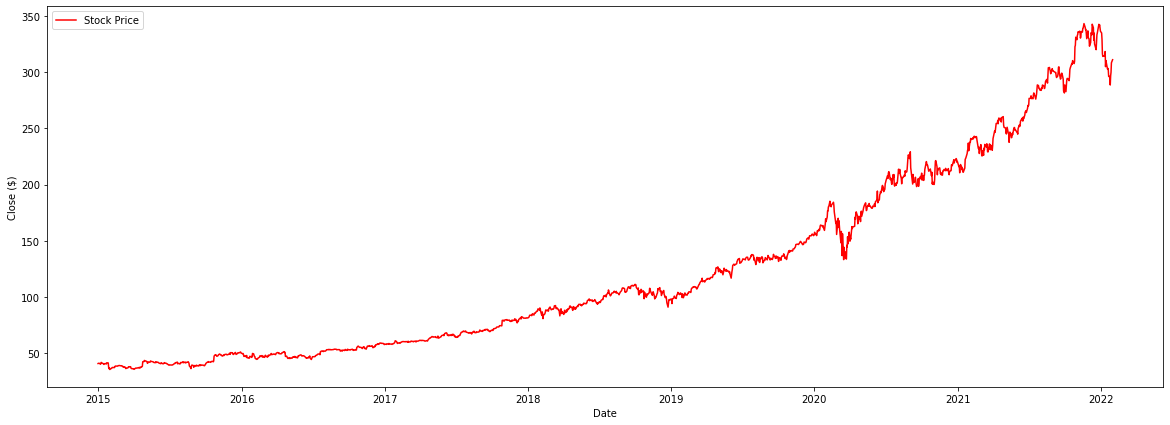

In [16]:
plt.figure(figsize=(20,7))
plt.plot(historical_data['Date'].values, historical_data['Close'].values, label = 'Stock Price', color = 'red')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

In [17]:
historical_data.reset_index( inplace=True )
plt.figure(figsize=(20,7))
candlestick = go.Figure( data = [go.Candlestick( x = historical_data['Date'],
                                                 open = historical_data['Open'],
                                                 high = historical_data['High'],
                                                 low = historical_data['Low'],
                                                 close = historical_data['Close']
                                               ) ] )
# Show the figure.
candlestick.update_xaxes( title_text = 'Date' )
candlestick.update_yaxes( title_text = 'Price' )
candlestick.show()

<Figure size 1440x504 with 0 Axes>

#### Plot of Microsoft stock  traded volume from 2010 up to now

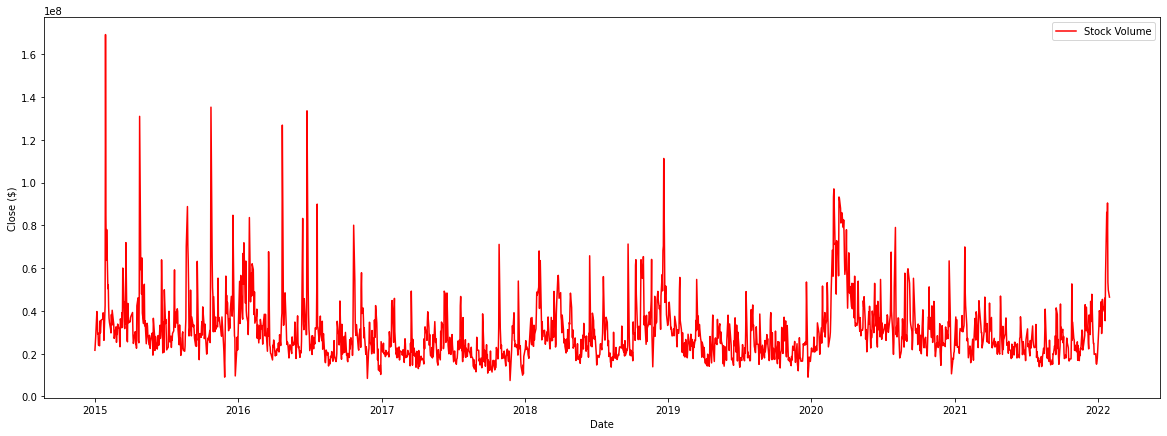

In [18]:
plt.figure(figsize=(20,7))
plt.plot(historical_data['Date'].values, historical_data['Volume'].values, label = 'Stock Volume', color = 'red')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

#### Plot of Microsoft stock  daily return percentage from 2010 up to now

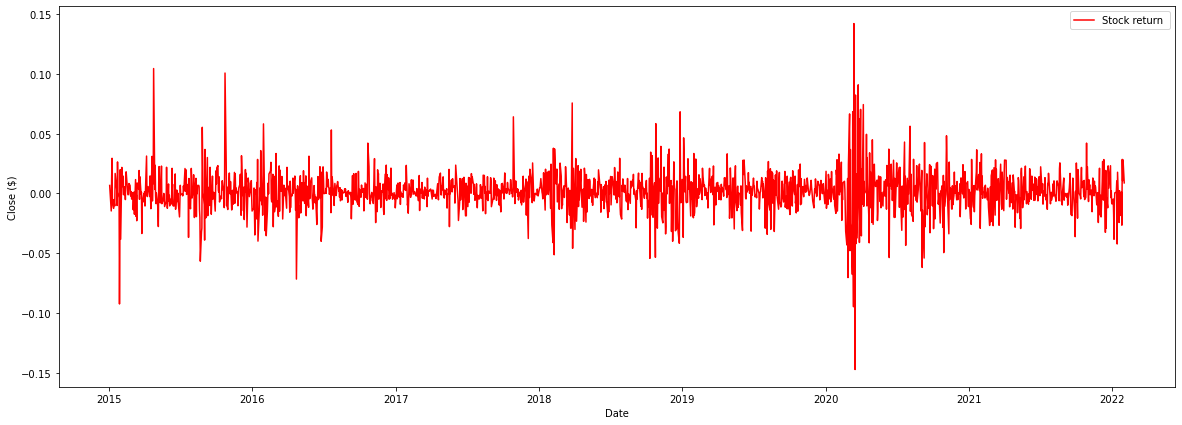

In [19]:
plt.figure(figsize=(20,7))
historical_data['Daily Return'] = historical_data['Close'].pct_change()

# Then we'll plot the daily return percentage

plt.plot(historical_data['Date'].values, historical_data['Daily Return'].values, label = 'Stock return ', color = 'red')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

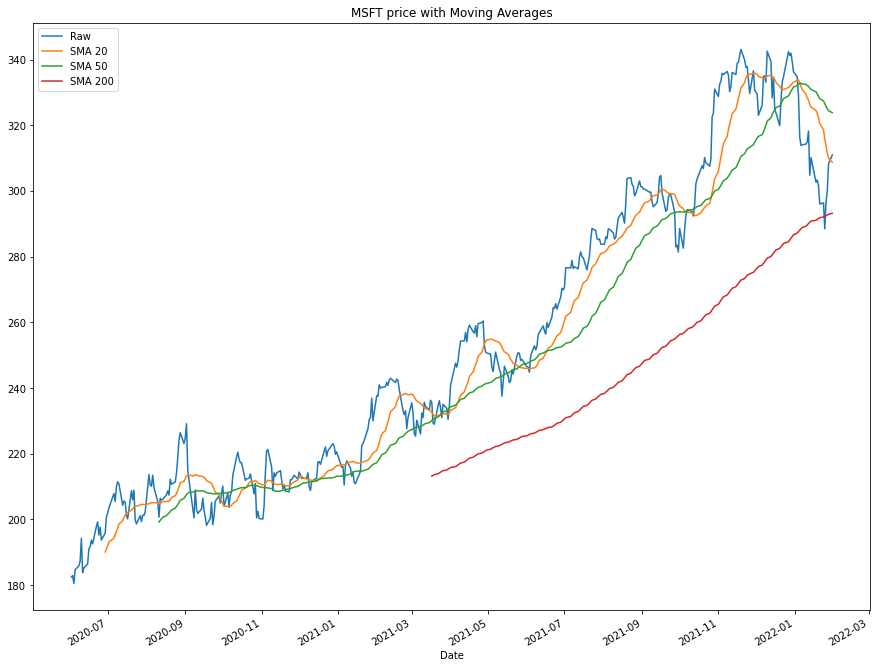

In [20]:
months = 6
name = "Stock name"
filtered_df = historical_data[(historical_data['Date'] > "2020-06-1")]
filtered_df.set_index('Date', inplace=True)
sma20 = filtered_df.Close.rolling(20).mean()
sma50 = filtered_df.Close.rolling(50).mean()
sma200 = filtered_df.Close.rolling(200).mean()
smaplot =pd.DataFrame({'Raw': filtered_df.Close, 'SMA 20': sma20, 'SMA 50': sma50, 'SMA 200': sma200})
smaplot.plot(figsize=(15,12), legend=True, title="MSFT price with Moving Averages")
plt.gcf().autofmt_xdate()
plt.show()

## FORECASTING  MICROSOFT STOCK PRICE USIG GRU MODEL

In [21]:
#Download the clean dataset
df = msft.history(start=start_date, end=end_date, interval="1d").reset_index()

date = "2020-05-01"
df = df[(df['Date']> date)]
df

Date        Open        High         Low       Close    Volume  \
1343 2020-05-04  171.693302  176.131011  171.014359  175.973572  30372900   
1344 2020-05-05  177.725053  180.706487  177.016592  177.862808  36839200   
1345 2020-05-06  179.161685  181.247701  178.718900  179.614304  32139300   
1346 2020-05-07  181.218175  181.592089  179.653662  180.657318  28316000   
1347 2020-05-08  182.015165  182.034849  180.421135  181.719971  30877800   
...         ...         ...         ...         ...         ...       ...   
1779 2022-01-25  291.519989  294.989990  285.170013  288.489990  72848600   
1780 2022-01-26  307.989990  308.500000  293.029999  296.709991  90428900   
1781 2022-01-27  302.660004  307.299988  297.929993  299.839996  53376900   
1782 2022-01-28  300.230011  308.480011  294.450012  308.260010  49717000   
1783 2022-01-31  308.950012  312.380005  306.369995  310.980011  46403600   

      Dividends  Stock Splits  
1343        0.0             0  
1344        0.0             0  
1345        0.0             0  
1346        0.0             0  
1347        0.0             0  
...         ...           ...  
1779        0.0             0  
1780        0.0             0  
1781        0.0             0  
1782        0.0             0  
1783        0.0             0  

[441 rows x 8 columns]

In [22]:
dfx = df.copy()

In [23]:
dfx.set_index('Date', inplace = True)

In [24]:
dfx

Open        High         Low       Close    Volume  \
Date                                                                   
2020-05-04  171.693302  176.131011  171.014359  175.973572  30372900   
2020-05-05  177.725053  180.706487  177.016592  177.862808  36839200   
2020-05-06  179.161685  181.247701  178.718900  179.614304  32139300   
2020-05-07  181.218175  181.592089  179.653662  180.657318  28316000   
2020-05-08  182.015165  182.034849  180.421135  181.719971  30877800   
...                ...         ...         ...         ...       ...   
2022-01-25  291.519989  294.989990  285.170013  288.489990  72848600   
2022-01-26  307.989990  308.500000  293.029999  296.709991  90428900   
2022-01-27  302.660004  307.299988  297.929993  299.839996  53376900   
2022-01-28  300.230011  308.480011  294.450012  308.260010  49717000   
2022-01-31  308.950012  312.380005  306.369995  310.980011  46403600   

            Dividends  Stock Splits  
Date                                 
2020-05-04        0.0             0  
2020-05-05        0.0             0  
2020-05-06        0.0             0  
2020-05-07        0.0             0  
2020-05-08        0.0             0  
...               ...           ...  
2022-01-25        0.0             0  
2022-01-26        0.0             0  
2022-01-27        0.0             0  
2022-01-28        0.0             0  
2022-01-31        0.0             0  

[441 rows x 7 columns]

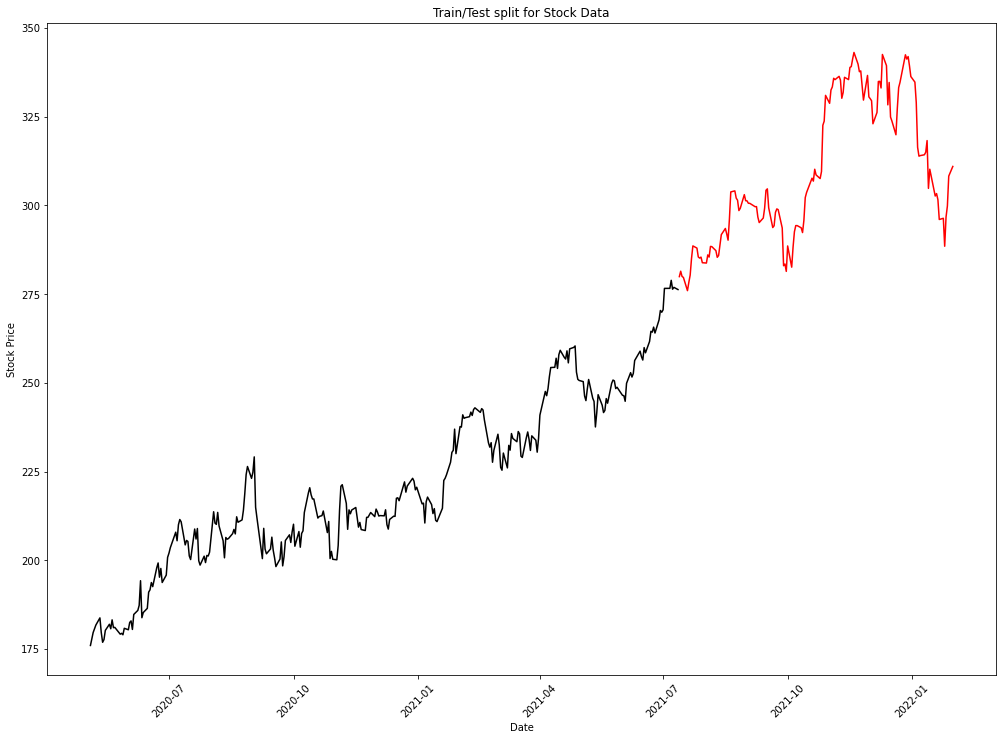

In [25]:
num_shape = 300

train = df.iloc[:num_shape, 4:5]
test = df.iloc[num_shape:, 4:5]

train_plt = dfx.iloc[:num_shape, 3:4]
test_plt = dfx.iloc[num_shape:, 3:4]


plt.figure(figsize=(17, 12))
plt.plot(train_plt, color = "black")
plt.plot(test_plt, color = "red")
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Stock Data")

plt.show()

In [26]:
train = df.iloc[:num_shape, 4:5].values
test = df.iloc[num_shape:, 4:5].values
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

X_train = []

y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [27]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [28]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=150, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=200))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 50)            7950      
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 100)           45600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 150)           113400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 200)               2

In [29]:
#epoch = [100,200,300,400,500]
epoch = [100]

In [30]:
for el in epoch:
    modelGRU.compile(optimizer='adam', loss='mean_squared_error')
    modelGRU.fit(X_train, y_train, epochs= el, batch_size=16)
    predict = modelGRU.predict(X_test)
    predict = sc.inverse_transform(predict)

    diff = predict - test

    print(mean_absolute_error(predict, test))

    print("MSE:", np.mean(diff**2))
    print("MAE:", np.mean(abs(diff)))
    print("RMSE:", np.sqrt(np.mean(diff**2)))

Epoch 1/100
15/15 [==============================] - 1s 96ms/step - loss: 0.0553
Epoch 2/100
15/15 [==============================] - 1s 92ms/step - loss: 0.0096
Epoch 3/100
15/15 [==============================] - 2s 103ms/step - loss: 0.0067
Epoch 4/100
15/15 [==============================] - 1s 95ms/step - loss: 0.0062
Epoch 5/100
15/15 [==============================] - 1s 98ms/step - loss: 0.0062
Epoch 6/100
15/15 [==============================] - 2s 101ms/step - loss: 0.0055
Epoch 7/100
15/15 [==============================] - 1s 90ms/step - loss: 0.0064
Epoch 8/100
15/15 [==============================] - 1s 96ms/step - loss: 0.0069: 0s - loss: 0.00
Epoch 9/100
15/15 [==============================] - 1s 93ms/step - loss: 0.0062
Epoch 10/100
15/15 [==============================] - 1s 90ms/step - loss: 0.0057
Epoch 11/100
15/15 [==============================] - 2s 103ms/step - loss: 0.0043
Epoch 12/100
15/15 [==============================] - 1s 93ms/step - loss: 0.0045
Epoch

In [31]:
predict

array([[275.90665],
       [278.3209 ],
       [280.06204],
       [279.71008],
       [279.55463],
       [277.09424],
       [277.949  ],
       [279.51288],
       [283.06085],
       [286.42697],
       [287.19623],
       [286.0486 ],
       [285.65826],
       [285.76706],
       [284.79648],
       [284.4776 ],
       [285.8451 ],
       [285.8399 ],
       [287.8233 ],
       [288.40128],
       [287.95813],
       [286.68762],
       [286.65567],
       [288.43912],
       [290.89154],
       [292.81522],
       [292.60205],
       [291.57794],
       [295.13406],
       [300.88257],
       [303.06125],
       [302.96985],
       [302.9074 ],
       [301.2612 ],
       [301.22394],
       [303.5331 ],
       [303.2338 ],
       [303.26907],
       [302.91238],
       [302.82477],
       [302.20935],
       [302.0306 ],
       [300.11246],
       [298.51947],
       [298.67728],
       [300.30225],
       [303.81454],
       [305.23715],
       [302.68066],
       [298.5998 ],


In [32]:
df2 = df.iloc[num_shape:]
df2
df2['prediction'] = predict
df2

D:\anaconda\envs\da2021\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date        Open        High         Low       Close    Volume  \
1643 2021-07-13  276.483865  281.793983  276.354376  279.930969  26120100   
1644 2021-07-14  281.295885  282.600992  279.502587  281.455292  23113700   
1645 2021-07-15  280.947154  281.455259  278.785242  279.980774  22604200   
1646 2021-07-16  281.016922  283.039342  278.416651  279.701843  26186800   
1647 2021-07-19  277.888614  279.323240  273.425360  275.975800  32935600   
...         ...         ...         ...         ...         ...       ...   
1779 2022-01-25  291.519989  294.989990  285.170013  288.489990  72848600   
1780 2022-01-26  307.989990  308.500000  293.029999  296.709991  90428900   
1781 2022-01-27  302.660004  307.299988  297.929993  299.839996  53376900   
1782 2022-01-28  300.230011  308.480011  294.450012  308.260010  49717000   
1783 2022-01-31  308.950012  312.380005  306.369995  310.980011  46403600   

      Dividends  Stock Splits  prediction  
1643        0.0             0  275.906647  
1644        0.0             0  278.320892  
1645        0.0             0  280.062042  
1646        0.0             0  279.710083  
1647        0.0             0  279.554626  
...         ...           ...         ...  
1779        0.0             0  301.386322  
1780        0.0             0  295.463043  
1781        0.0             0  298.381500  
1782        0.0             0  300.728363  
1783        0.0             0  306.470123  

[141 rows x 9 columns]

<AxesSubplot:xlabel='Date'>

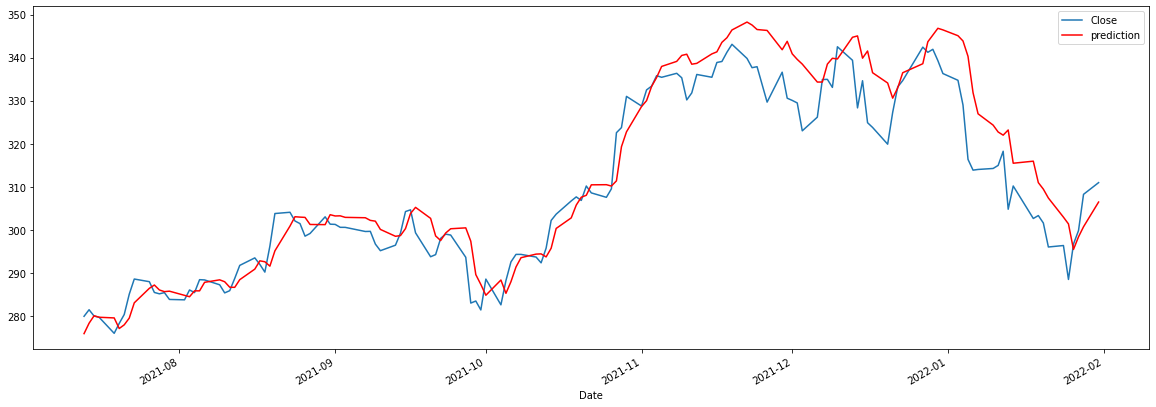

In [33]:
plt.figure(figsize=(20,7))
ax = plt.gca()
df2.plot(x="Date", y="Close", ax=ax)
df2.plot(x="Date", y="prediction", color='red', ax=ax)

#### Predict the stock price 20 days into the future

#### Define new training and testing sets with se same time windows as before ( 60 days )

In [34]:

pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [35]:
X_test_2

[array([[1.40000557],
        [1.43148919],
        [1.48017169],
        [1.52341292],
        [1.54974619],
        [1.62447075],
        [1.60649404],
        [1.61242163],
        [1.57938354],
        [1.54867745],
        [1.54362437],
        [1.45646193],
        [1.33295761],
        [1.34267472],
        [1.29739298],
        [1.33519265],
        [1.39631332],
        [1.40408689],
        [1.24647544],
        [1.24472644],
        [1.26629842],
        [1.29331196],
        [1.23131679],
        [1.12938445],
        [1.1227766 ],
        [1.28281732],
        [1.23102528],
        [1.20741279],
        [1.29214595],
        [1.26804861],
        [0.97268903],
        [1.00353271],
        [1.01068294],
        [1.01468775],
        [0.99683263],
        [0.9866633 ],
        [0.98922691],
        [1.02116424],
        [1.05264104],
        [1.07325697],
        [1.08395177],
        [1.08631106],
        [1.07137363],
        [1.06120518],
        [1.06562841],
        [1

#### Append the new 20 dates to the original dataframe

In [36]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(20):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

In [37]:
#new_dataframe with predicted days
df3 = df_date[-20:]
df3

Date
441  2022-02-01
442  2022-02-02
443  2022-02-03
444  2022-02-04
445  2022-02-05
446  2022-02-06
447  2022-02-07
448  2022-02-08
449  2022-02-09
450  2022-02-10
451  2022-02-11
452  2022-02-12
453  2022-02-13
454  2022-02-14
455  2022-02-15
456  2022-02-16
457  2022-02-17
458  2022-02-18
459  2022-02-19
460  2022-02-20

#### Dataframe with predictions

In [38]:
df3['price'] = prediction_full
df3

D:\anaconda\envs\da2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date       price
441  2022-02-01  308.526581
442  2022-02-02  308.526581
443  2022-02-03  308.475769
444  2022-02-04  285.469086
445  2022-02-05  281.181580
446  2022-02-06  283.403412
447  2022-02-07  286.103729
448  2022-02-08  288.369568
449  2022-02-09  292.165497
450  2022-02-10  303.602631
451  2022-02-11  303.065948
452  2022-02-12  301.203552
453  2022-02-13  295.136932
454  2022-02-14  320.590729
455  2022-02-15  348.181396
456  2022-02-16  347.859955
457  2022-02-17  350.526855
458  2022-02-18  316.930298
459  2022-02-19  286.907318
460  2022-02-20  295.102661

#### Plot of the real stock price and the predicted stock price

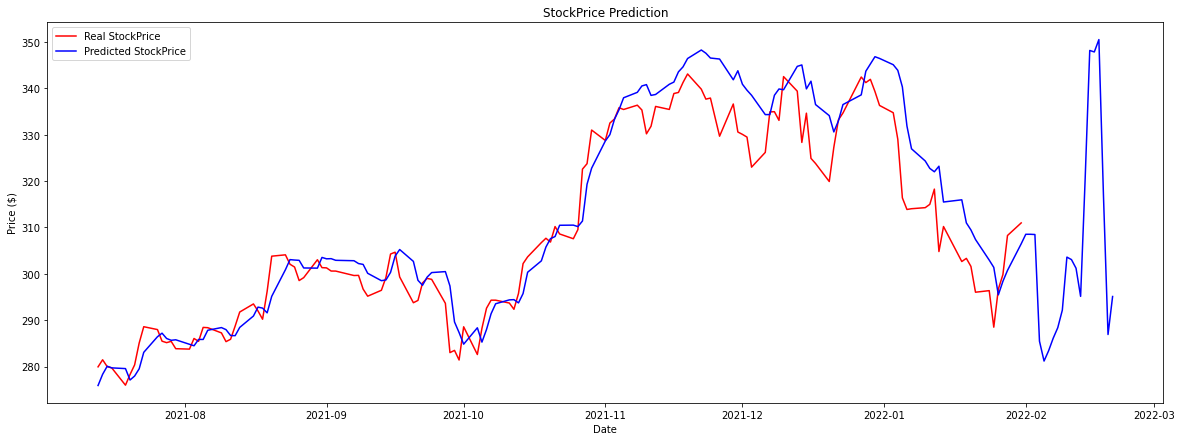

In [39]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_shape:], df_volume[num_shape:], color = 'red', label = 'Real StockPrice')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted StockPrice')
plt.title('StockPrice Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

#### Plot of only next 20 days predicted stock prices

<AxesSubplot:xlabel='Date'>

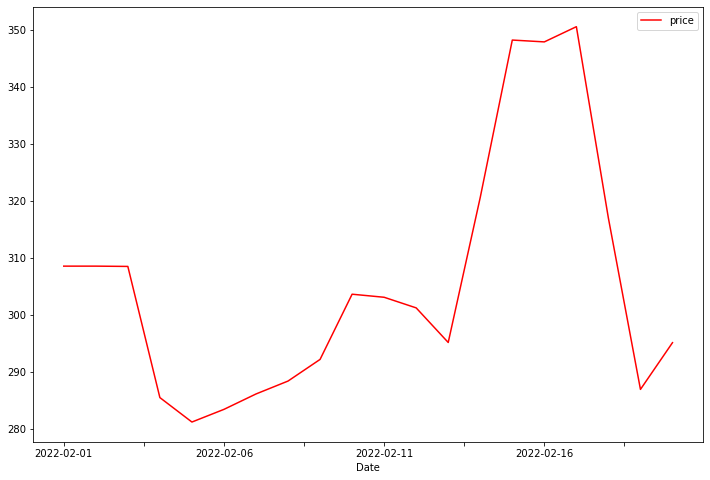

In [40]:
df3.plot(x="Date", y="price", color='red',figsize=(12,8))

## LSTM MODEL

In [41]:

from datetime import datetime
#Download the clean dataset
df = msft.history(start=start_date, end=end_date, interval="1d").reset_index()

date = "2020-05-01"
df = df[(df['Date']> date)]

df = df.sort_values('Date').reset_index(drop=True)

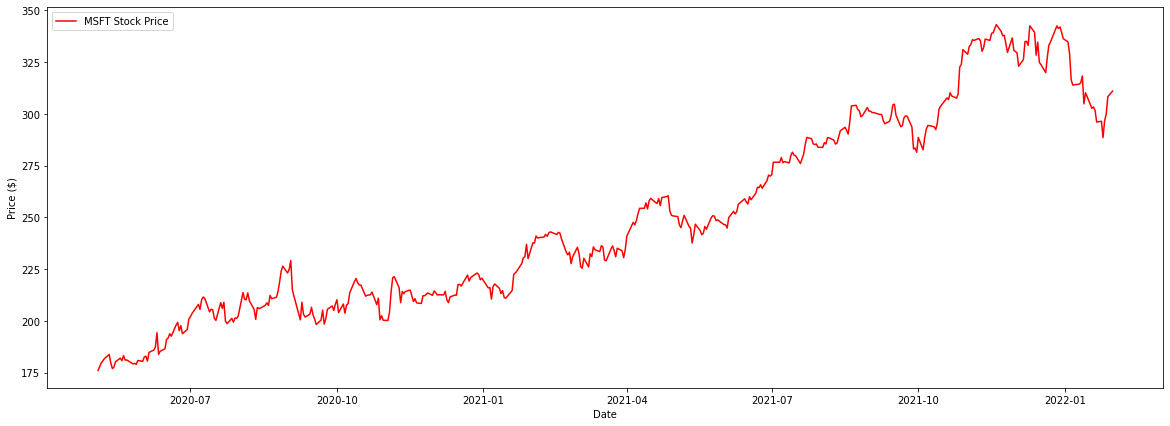

In [42]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'MSFT Stock Price', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [43]:
num_shape = 300

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [35]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [36]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [46]:
# Initializing the Recurrent Neural Network

#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [47]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32);

Epoch 1/100
8/8 [==============================] - 1s 63ms/step - loss: 0.0911
Epoch 2/100
8/8 [==============================] - 0s 59ms/step - loss: 0.0148
Epoch 3/100
8/8 [==============================] - 0s 58ms/step - loss: 0.0092
Epoch 4/100
8/8 [==============================] - 0s 60ms/step - loss: 0.0080
Epoch 5/100
8/8 [==============================] - 0s 60ms/step - loss: 0.0063
Epoch 6/100
8/8 [==============================] - 0s 56ms/step - loss: 0.0053
Epoch 7/100
8/8 [==============================] - 0s 54ms/step - loss: 0.0049
Epoch 8/100
8/8 [==============================] - 0s 55ms/step - loss: 0.0047
Epoch 9/100
8/8 [==============================] - 0s 54ms/step - loss: 0.0047
Epoch 10/100
8/8 [==============================] - 0s 55ms/step - loss: 0.0048
Epoch 11/100
8/8 [==============================] - 1s 64ms/step - loss: 0.0050
Epoch 12/100
8/8 [==============================] - 0s 53ms/step - loss: 0.0045
Epoch 13/100
8/8 [==============================]

In [48]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [49]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

In [50]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 42.68546117437809
MAE: 4.910215960991568
RMSE: 6.53341114383429


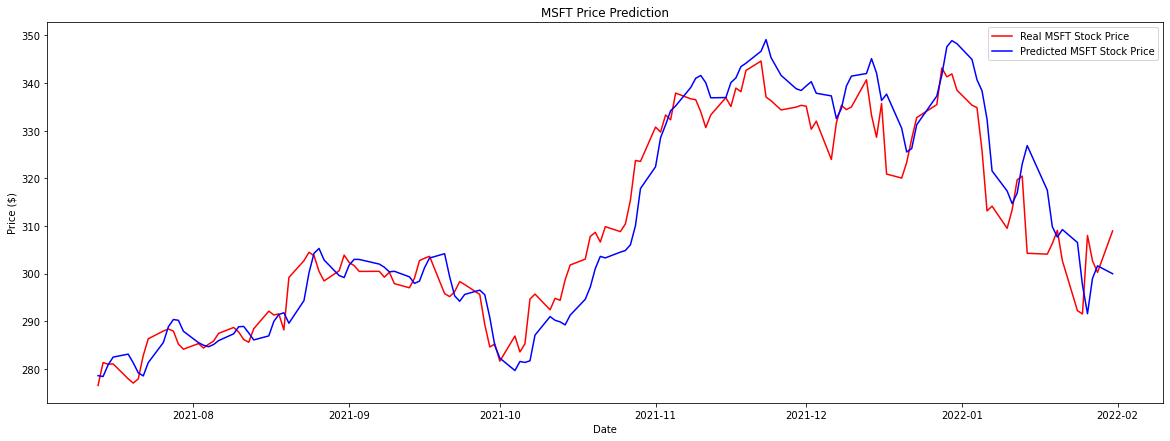

In [51]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[300:], df_volume[300:], color = 'red', label = 'Real MSFT Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()



In [52]:
predict

array([[278.5517 ],
       [278.3742 ],
       [280.81247],
       [282.44687],
       [283.07166],
       [281.25812],
       [279.16772],
       [278.49756],
       [281.2972 ],
       [285.51013],
       [288.81665],
       [290.3403 ],
       [290.1765 ],
       [287.875  ],
       [285.4769 ],
       [284.94928],
       [284.6325 ],
       [285.0821 ],
       [285.90854],
       [287.33673],
       [288.8235 ],
       [288.88834],
       [287.51993],
       [286.05463],
       [286.90402],
       [289.94507],
       [291.39594],
       [291.76233],
       [289.56155],
       [294.31403],
       [300.1578 ],
       [304.25165],
       [305.26245],
       [302.85   ],
       [299.57318],
       [299.1611 ],
       [301.78253],
       [302.9737 ],
       [302.95526],
       [301.97647],
       [301.32373],
       [300.34665],
       [300.4676 ],
       [299.3002 ],
       [297.92572],
       [298.40854],
       [301.21176],
       [303.25464],
       [304.1623 ],
       [299.35233],


In [53]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [54]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [55]:
df_date = df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

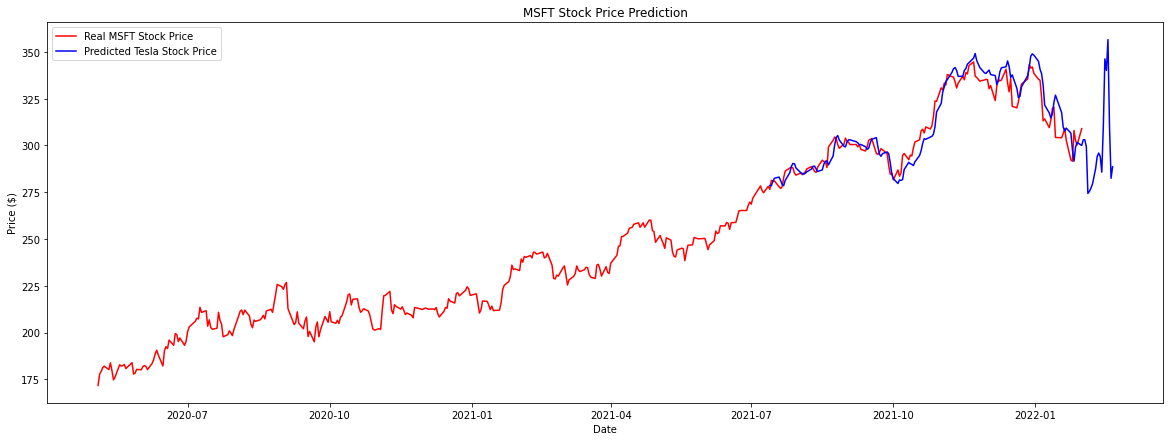

In [56]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'], df_volume, color = 'red', label = 'Real MSFT Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [57]:
df4 = df_date[-20:]
df4['price'] = prediction_full
df4

D:\anaconda\envs\da2021\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date       price
441  2022-02-01  303.016235
442  2022-02-02  303.016235
443  2022-02-03  299.256287
444  2022-02-04  274.343628
445  2022-02-05  275.455505
446  2022-02-06  277.209320
447  2022-02-07  279.430786
448  2022-02-08  283.480591
449  2022-02-09  287.529877
450  2022-02-10  293.988159
451  2022-02-11  295.900848
452  2022-02-12  293.975586
453  2022-02-13  285.715637
454  2022-02-14  310.259216
455  2022-02-15  346.196991
456  2022-02-16  340.079224
457  2022-02-17  356.540955
458  2022-02-18  309.953888
459  2022-02-19  282.430969
460  2022-02-20  288.543701

<AxesSubplot:xlabel='Date'>

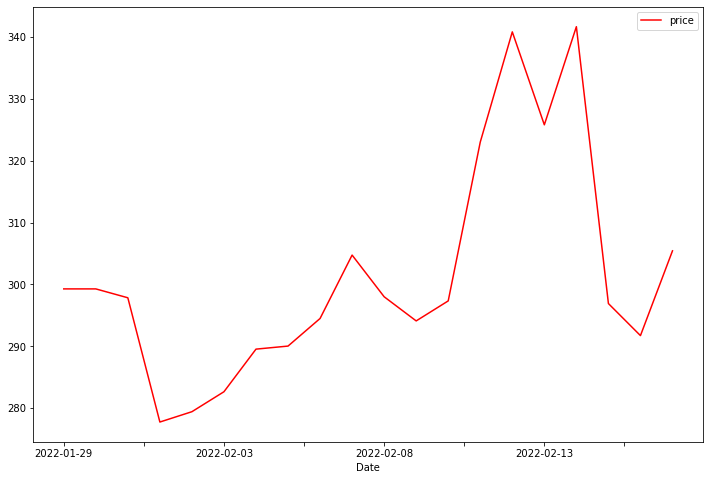

In [54]:
df4.plot(x="Date", y="price", color='red',figsize=(12,8))

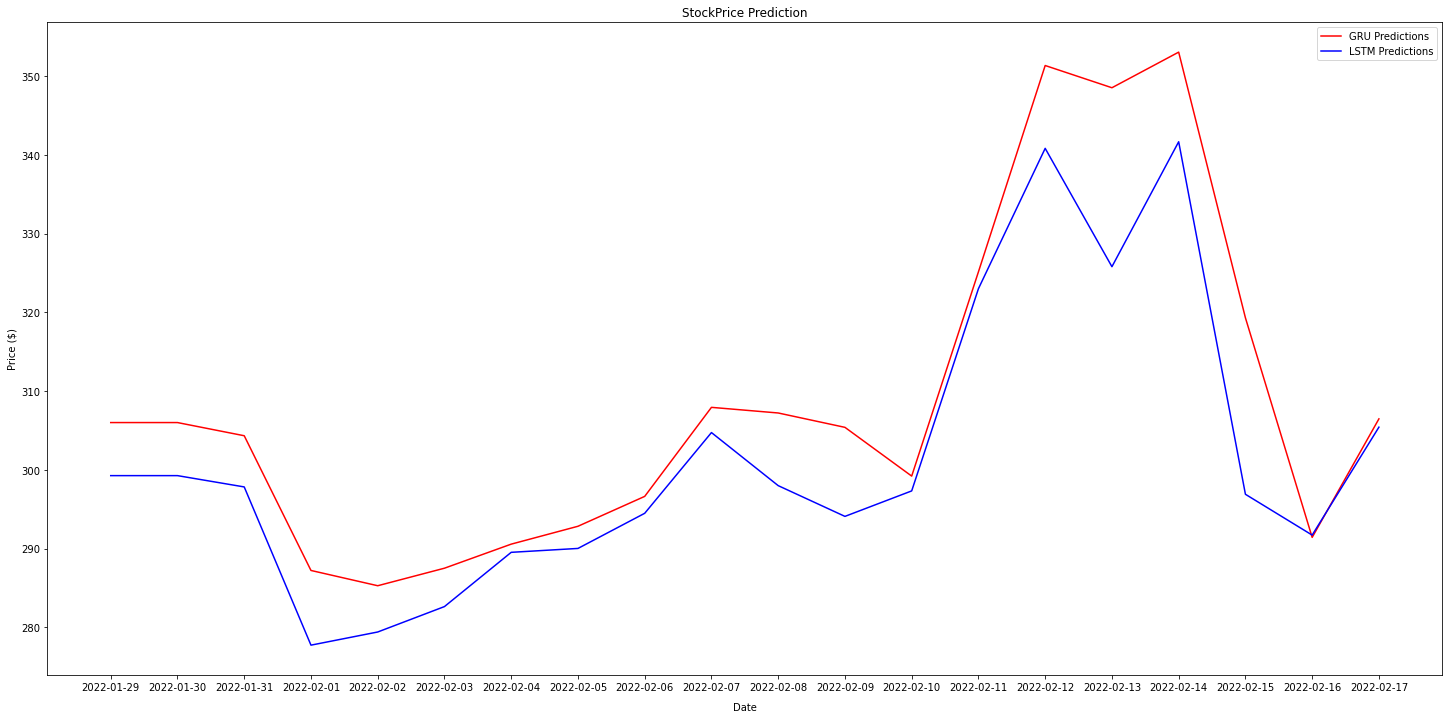

In [79]:
plt.figure(figsize=(25,12))
plt.plot(df3['Date'], df3['price'], color = 'red', label = 'GRU Predictions')
plt.plot(df4['Date'], df4['price'], color = 'blue', label = 'LSTM Predictions')
plt.title('StockPrice Prediction')
plt.xlabel('Date', labelpad = 10)
plt.ylabel('Price ($)')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

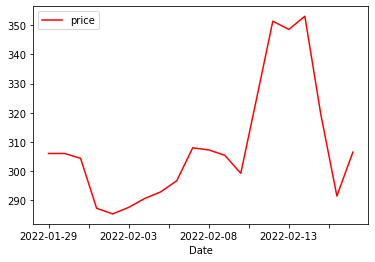

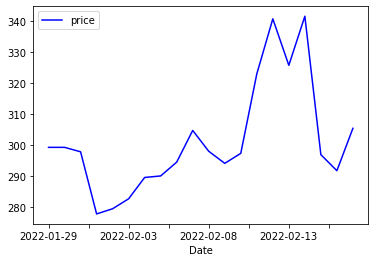

In [80]:
df3.plot(x="Date", y="price", color='red')
df4.plot(x="Date", y="price", color='blue')

#### MODELLING WITH FACEBOOK PROPHET

#### CREATING LAG FEATURES
#### A lag features is a fancy name for a variable which contains data from prior time steps. If we have time-series data, we can convert it into rows. Every row contains data about one observation and includes all previous occurrences of that observation.

In [81]:
# Create lag features
for i in range(1, 7):
    historical_data[f"Close_lag_{i}"] = historical_data.Close.shift(periods=i, axis=0)
    historical_data[f"Open_lag_{i}"] = historical_data.Open.shift(periods=i, axis=0)
    historical_data[f"High_lag_{i}"] = historical_data.High.shift(periods=i, axis=0)
    historical_data[f"Low_lag_{i}"] = historical_data.Low.shift(periods=i, axis=0)

historical_data.head()

index       Date       Open       High        Low      Close    Volume  \
0      0 2014-12-31  41.167407  41.792890  40.920738  40.920738  21552500   
1      1 2015-01-02  41.105749  41.775280  41.000034  41.193844  27913900   
2      2 2015-01-05  40.850265  41.167412  40.744550  40.815029  39673900   
3      3 2015-01-06  40.859068  41.185023  40.119059  40.215965  36447900   
4      4 2015-01-07  40.506684  40.929546  40.075014  40.726925  29114100   

   Dividends  Stock Splits  Daily Return  ...  High_lag_4  Low_lag_4  \
0        0.0             0           NaN  ...         NaN        NaN   
1        0.0             0      0.006674  ...         NaN        NaN   
2        0.0             0     -0.009196  ...         NaN        NaN   
3        0.0             0     -0.014678  ...         NaN        NaN   
4        0.0             0      0.012705  ...    41.79289  40.920738   

   Close_lag_5  Open_lag_5  High_lag_5  Low_lag_5  Close_lag_6  Open_lag_6  \
0          NaN         NaN         NaN        NaN          NaN         NaN   
1          NaN         NaN         NaN        NaN          NaN         NaN   
2          NaN         NaN         NaN        NaN          NaN         NaN   
3          NaN         NaN         NaN        NaN          NaN         NaN   
4          NaN         NaN         NaN        NaN          NaN         NaN   

   High_lag_6  Low_lag_6  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  

[5 rows x 34 columns]

In [83]:
historical_data.fillna(0, inplace=True)
historical_data.head()

index       Date       Open       High        Low      Close    Volume  \
0      0 2014-12-31  41.167407  41.792890  40.920738  40.920738  21552500   
1      1 2015-01-02  41.105749  41.775280  41.000034  41.193844  27913900   
2      2 2015-01-05  40.850265  41.167412  40.744550  40.815029  39673900   
3      3 2015-01-06  40.859068  41.185023  40.119059  40.215965  36447900   
4      4 2015-01-07  40.506684  40.929546  40.075014  40.726925  29114100   

   Dividends  Stock Splits  Daily Return  ...  High_lag_4  Low_lag_4  \
0        0.0             0      0.000000  ...     0.00000   0.000000   
1        0.0             0      0.006674  ...     0.00000   0.000000   
2        0.0             0     -0.009196  ...     0.00000   0.000000   
3        0.0             0     -0.014678  ...     0.00000   0.000000   
4        0.0             0      0.012705  ...    41.79289  40.920738   

   Close_lag_5  Open_lag_5  High_lag_5  Low_lag_5  Close_lag_6  Open_lag_6  \
0          0.0         0.0         0.0        0.0          0.0         0.0   
1          0.0         0.0         0.0        0.0          0.0         0.0   
2          0.0         0.0         0.0        0.0          0.0         0.0   
3          0.0         0.0         0.0        0.0          0.0         0.0   
4          0.0         0.0         0.0        0.0          0.0         0.0   

   High_lag_6  Low_lag_6  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0  
3         0.0        0.0  
4         0.0        0.0  

[5 rows x 34 columns]

In [84]:
validation_period = 300 # 30 days

train, validation = historical_data.iloc[:-validation_period], historical_data.iloc[-validation_period:]

train.shape, validation.shape

((1482, 34), (300, 34))

In [86]:
lag_features = [col for col in historical_data.columns if "lag" in col]

In [87]:
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")
for name in lag_features:
    model.add_regressor(name)

model.fit(df=train.rename(columns={"Date": "ds", "Close":"y"}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Forecast of testing set

In [88]:
forecast = model.predict(validation[[col for col in validation.columns if col != "Close"]].rename(columns={"Date": "ds"}))

forecast.shape

(300, 94)

In [89]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-06-01 00:00:00 and 2019-11-18 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2017-06-02  65.491220   64.269189   66.753983  67.510147 2017-06-01
1 2017-06-05  66.204433   65.007951   67.348785  67.999336 2017-06-01
2 2017-06-06  66.310629   65.057167   67.482226  68.225105 2017-06-01
3 2017-06-07  66.658578   65.365457   67.857452  68.102829 2017-06-01
4 2017-06-08  66.498119   65.268601   67.618913  67.688881 2017-06-01

In [90]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  5.102952  2.258972  1.683329  0.016824  0.013170  0.533333
1 38 days  5.209065  2.282338  1.704265  0.016935  0.013349  0.530000
2 39 days  5.229999  2.286919  1.711541  0.016951  0.013349  0.526667
3 40 days  5.522124  2.349920  1.777205  0.017593  0.013901  0.506667
4 41 days  6.003430  2.450190  1.838950  0.018188  0.014396  0.496667

In [91]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2020-11-18  105.732276  212.533241  217.848431   105.732276   105.732276   
1   2020-11-19  105.764274  209.452349  214.804070   105.764274   105.764274   
2   2020-11-20  105.796272  209.895725  215.468425   105.796272   105.796272   
3   2020-11-23  105.892267  210.207812  215.819759   105.892267   105.892267   
4   2020-11-24  105.924265  208.334867  213.804845   105.924265   105.924265   
..         ...         ...         ...         ...          ...          ...   
295 2022-01-21  119.459519  298.285078  306.235198   116.590591   122.475743   
296 2022-01-24  119.555514  297.792140  305.878080   116.653085   122.605376   
297 2022-01-25  119.587512  286.119754  294.476382   116.673388   122.649547   
298 2022-01-26  119.619510  289.479216  297.670854   116.693691   122.693718   
299 2022-01-28  119.683507  289.614606  297.735136   116.734297   122.782060   

     Close_lag_1  Close_lag_1_lower  Close_lag_1_upper  Close_lag_2  ...  \
0      24.101388          24.101388          24.101388    36.608100  ...   
1      23.534215          23.534215          23.534215    35.784099  ...   
2      23.803722          23.803722          23.803722    34.943026  ...   
3      23.395435          23.395435          23.395435    35.342684  ...   
4      23.339122          23.339122          23.339122    34.737226  ...   
..           ...                ...                ...          ...  ...   
295    42.248537          42.248537          42.248537    63.215216  ...   
296    41.118878          41.118878          41.118878    62.694919  ...   
297    41.187833          41.187833          41.187833    61.019721  ...   
298    39.589680          39.589680          39.589680    61.121976  ...   
299    41.256788          41.256788          41.256788    58.752039  ...   

       weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0    7.790985      7.790985      7.790985 -0.097559     -0.097559   
1    7.534832      7.534832      7.534832 -0.103950     -0.103950   
2    7.516789      7.516789      7.516789 -0.112449     -0.112449   
3    7.601172      7.601172      7.601172 -0.147871     -0.147871   
4    7.455572      7.455572      7.455572 -0.161868     -0.161868   
..        ...           ...           ...       ...           ...   
295  7.516789      7.516789      7.516789 -0.340218     -0.340218   
296  7.601172      7.601172      7.601172 -0.304460     -0.304460   
297  7.455572      7.455572      7.455572 -0.281476     -0.281476   
298  7.790985      7.790985      7.790985 -0.253504     -0.253504   
299  7.516789      7.516789      7.516789 -0.184617     -0.184617   

     yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0       -0.097559                   0.0                         0.0   
1       -0.103950                   0.0                         0.0   
2       -0.112449                   0.0                         0.0   
3       -0.147871                   0.0                         0.0   
4       -0.161868                   0.0                         0.0   
..            ...                   ...                         ...   
295     -0.340218                   0.0                         0.0   
296     -0.304460                   0.0                         0.0   
297     -0.281476                   0.0                         0.0   
298     -0.253504                   0.0                         0.0   
299     -0.184617                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  215.242476  
1                           0.0  212.107019  
2                           0.0  212.672102  
3                           0.0  212.921205  
4                           0.0  211.055133  
..                          ...         ...  
295                         0.0  302.227801  
296                         0.0  301.681704  
297                         0.0  290.16067

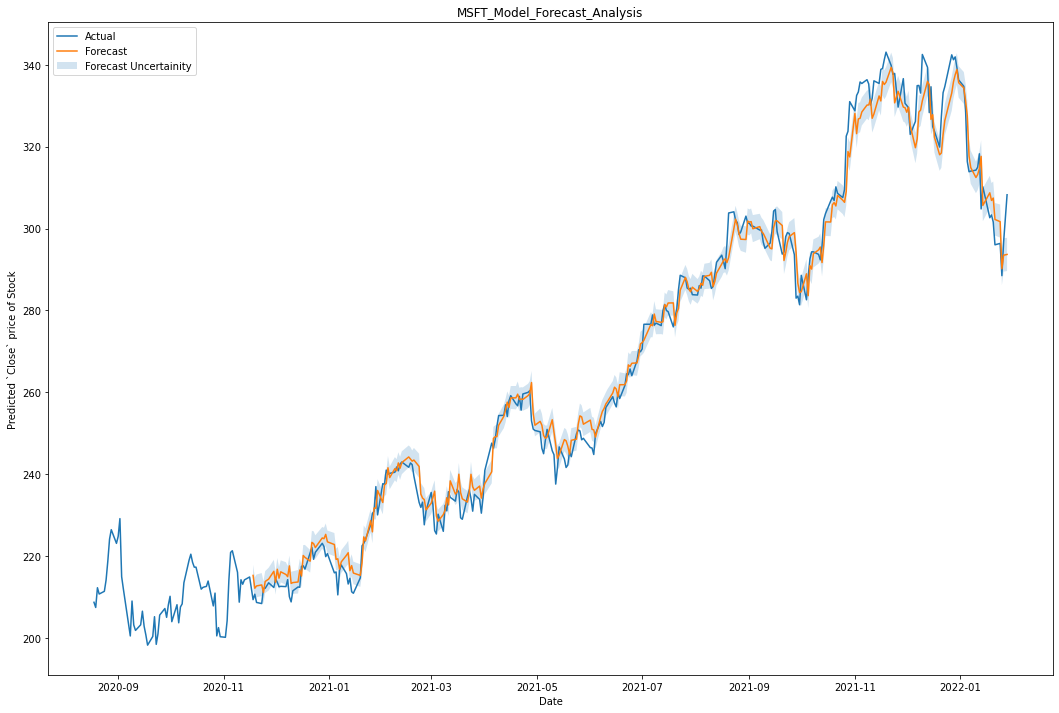

In [92]:
# Plotting predictions and uncertainity interval with respect to actuals
fig = plt.figure(figsize=(18, 12))

# Plot actuals
plt.plot(historical_data.Date.iloc[-365:], historical_data.Close.iloc[-365:])

# Plot forecasts for the latest 365 days as validation period
plt.plot(forecast.ds, forecast.yhat)

# Plot uncertainity - lower and upper bound for the forecasts
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, alpha=0.2)

plt.xlabel("Date")
plt.ylabel("Predicted `Close` price of Stock")
plt.legend(["Actual", "Forecast", "Forecast Uncertainity"])
plt.title(f"{ticker}_Model_Forecast_Analysis")
plt.show()

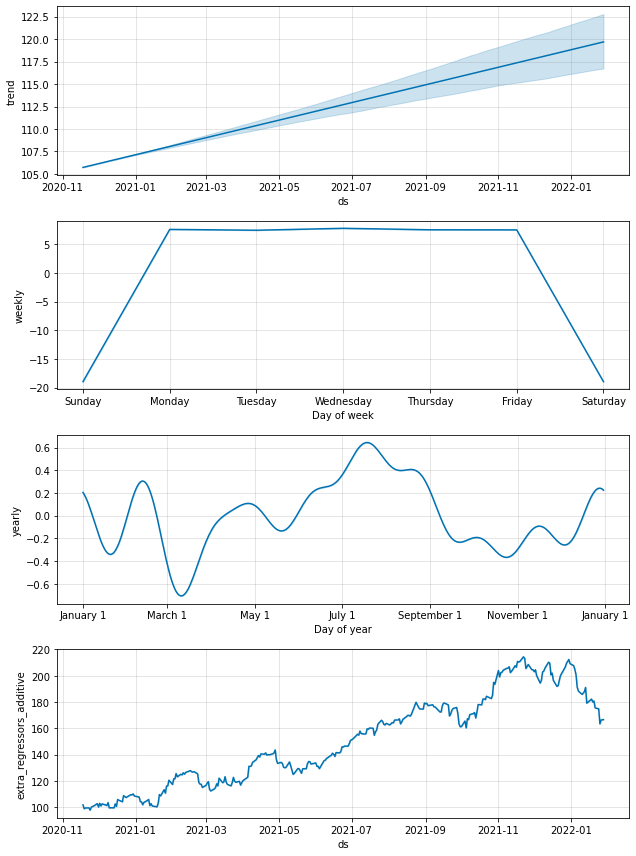

In [93]:
fig2 = model.plot_components(forecast)

In [97]:
# Add placeholder for forecast
from datetime import date, timedelta, datetime
historical_data2 = msft.history(start=start_date, end=end_date, interval="1d").reset_index()

historical_data2.drop(
    columns=["Dividends", "Stock Splits", "Volume"], inplace=True)

historical_data2.shape
present_date = historical_data2.Date.max()
day_number = pd.to_datetime(present_date).isoweekday()

if day_number in [5, 6]:
    next_date = present_date + timedelta(days=(7-day_number) + 1)
else:
    next_date = present_date + timedelta(days=1)
print("Present date:", present_date)
print("Next valid date:", next_date)

test_row = pd.DataFrame([[next_date, 0.0, 0.0, 0.0, 0.0]], columns=historical_data2.columns)
test_row.head()

Present date: 2022-01-28 00:00:00
Next valid date: 2022-01-31 00:00:00


Date  Open  High  Low  Close
0 2022-01-31   0.0   0.0  0.0    0.0

In [98]:
historical_data2 = pd.concat([historical_data2, test_row])
historical_data2

Date        Open        High         Low       Close
0    2014-12-31   41.167399   41.792882   40.920731   40.920731
1    2015-01-02   41.105749   41.775280   41.000034   41.193844
2    2015-01-05   40.850261   41.167409   40.744547   40.815025
3    2015-01-06   40.859068   41.185023   40.119059   40.215965
4    2015-01-07   40.506684   40.929546   40.075014   40.726925
...         ...         ...         ...         ...         ...
1778 2022-01-24  292.200012  297.109985  276.049988  296.369995
1779 2022-01-25  291.519989  294.989990  285.170013  288.489990
1780 2022-01-26  307.989990  308.500000  293.029999  296.709991
1781 2022-01-28  300.230011  308.480011  294.450012  308.260010
0    2022-01-31    0.000000    0.000000    0.000000    0.000000

[1783 rows x 5 columns]

In [99]:
# Create lag features
for i in range(1, 7):
    historical_data2[f"Close_lag_{i}"] = historical_data2.Close.shift(periods=i, axis=0)
    historical_data2[f"Open_lag_{i}"] = historical_data2.Open.shift(periods=i, axis=0)
    historical_data2[f"High_lag_{i}"] = historical_data2.High.shift(periods=i, axis=0)
    historical_data2[f"Low_lag_{i}"] = historical_data2.Low.shift(periods=i, axis=0)

historical_data2.head()

Date       Open       High        Low      Close  Close_lag_1  \
0 2014-12-31  41.167399  41.792882  40.920731  40.920731          NaN   
1 2015-01-02  41.105749  41.775280  41.000034  41.193844    40.920731   
2 2015-01-05  40.850261  41.167409  40.744547  40.815025    41.193844   
3 2015-01-06  40.859068  41.185023  40.119059  40.215965    40.815025   
4 2015-01-07  40.506684  40.929546  40.075014  40.726925    40.215965   

   Open_lag_1  High_lag_1  Low_lag_1  Close_lag_2  ...  High_lag_4  Low_lag_4  \
0         NaN         NaN        NaN          NaN  ...         NaN        NaN   
1   41.167399   41.792882  40.920731          NaN  ...         NaN        NaN   
2   41.105749   41.775280  41.000034    40.920731  ...         NaN        NaN   
3   40.850261   41.167409  40.744547    41.193844  ...         NaN        NaN   
4   40.859068   41.185023  40.119059    40.815025  ...   41.792882  40.920731   

   Close_lag_5  Open_lag_5  High_lag_5  Low_lag_5  Close_lag_6  Open_lag_6  \
0          NaN         NaN         NaN        NaN          NaN         NaN   
1          NaN         NaN         NaN        NaN          NaN         NaN   
2          NaN         NaN         NaN        NaN          NaN         NaN   
3          NaN         NaN         NaN        NaN          NaN         NaN   
4          NaN         NaN         NaN        NaN          NaN         NaN   

   High_lag_6  Low_lag_6  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  

[5 rows x 29 columns]

In [100]:
historical_data2.fillna(0, inplace=True)
historical_data2.head()

Date       Open       High        Low      Close  Close_lag_1  \
0 2014-12-31  41.167399  41.792882  40.920731  40.920731     0.000000   
1 2015-01-02  41.105749  41.775280  41.000034  41.193844    40.920731   
2 2015-01-05  40.850261  41.167409  40.744547  40.815025    41.193844   
3 2015-01-06  40.859068  41.185023  40.119059  40.215965    40.815025   
4 2015-01-07  40.506684  40.929546  40.075014  40.726925    40.215965   

   Open_lag_1  High_lag_1  Low_lag_1  Close_lag_2  ...  High_lag_4  Low_lag_4  \
0    0.000000    0.000000   0.000000     0.000000  ...    0.000000   0.000000   
1   41.167399   41.792882  40.920731     0.000000  ...    0.000000   0.000000   
2   41.105749   41.775280  41.000034    40.920731  ...    0.000000   0.000000   
3   40.850261   41.167409  40.744547    41.193844  ...    0.000000   0.000000   
4   40.859068   41.185023  40.119059    40.815025  ...   41.792882  40.920731   

   Close_lag_5  Open_lag_5  High_lag_5  Low_lag_5  Close_lag_6  Open_lag_6  \
0          0.0         0.0         0.0        0.0          0.0         0.0   
1          0.0         0.0         0.0        0.0          0.0         0.0   
2          0.0         0.0         0.0        0.0          0.0         0.0   
3          0.0         0.0         0.0        0.0          0.0         0.0   
4          0.0         0.0         0.0        0.0          0.0         0.0   

   High_lag_6  Low_lag_6  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0  
3         0.0        0.0  
4         0.0        0.0  

[5 rows x 29 columns]

In [101]:
historical_data2.drop(
    columns=["Open", "High", "Low"], inplace=True)
lag_features = [col for col in historical_data2.columns if "lag" in col]

In [102]:
model2 = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")
for name in lag_features:
    model2.add_regressor(name)

model2.fit(df=historical_data2.iloc[:-1, :].rename(columns={"Date": "ds", "Close":"y"}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
forecast = model2.predict(
    historical_data2.iloc[-1:][[col for col in historical_data2.columns if col != "Close"]].rename(columns={"Date": "ds"})
)

forecast.shape

(1, 94)

In [105]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-01-31  124.856759  302.720092  308.994963   124.856759   124.856759   

   Close_lag_1  Close_lag_1_lower  Close_lag_1_upper  Close_lag_2  ...  \
0    85.332425          85.332425          85.332425    59.289351  ...   

      weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0  12.905269     12.905269     12.905269  0.201805      0.201805   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      0.201805                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  305.729833  

[1 rows x 94 columns]